Create The base configurations of the model 


In [22]:
# configurations of the model 
T_total     = 200.0       # max simulated time (s)
dt          = 0.05        # integration step
g_list      = [0.5, 1.0, 1.5, 2.0, 2.5]      # random gain (chaos driver)
Ns          = list(range(100,500 , 50))     # network sizes to test
trials_perN = 20                           # how many random (J, x0) trials per N
rel_tol     = 1e-3                            # relative tolerance for ||dx|| / ||x||
abs_tol     = 1e-5                            # absolute tolerance for ||dx||
hold_steps  = 20                              # require this many consecutive "quiet" steps
integrator  = "euler"                         # "euler" or "heun" (2nd order)
seed_base   = 12345                           # base RNG seed (varied per trial)


Import all the necessary libraries 


In [14]:
#!pip install numpy 
#!pip install matplotlib 
import numpy as np
import matplotlib.pyplot as plt

Define the necessary utilities 

In [15]:
def rhs(x, s, g, J):
    u = np.tanh(x)
    return -x + s * u + g * (J @ u)

def step_euler(x, s, g, J, dt):
    return x + dt * rhs(x, s, g, J)

def step_heun(x, s, g, J, dt):
    # Predict
    k1 = rhs(x, s, g, J)
    x_pred = x + dt * k1
    # Correct
    k2 = rhs(x_pred, s, g, J)
    return x + 0.5 * dt * (k1 + k2)


In [16]:
def time_to_convergence(
    N, s, g, dt=0.05, T_total=200.0,
    rel_tol=1e-3, abs_tol=1e-5, hold_steps=20,
    rng=None, integrator="euler"
):
    if rng is None:
        rng = np.random.default_rng()

    steps = int(np.ceil(T_total / dt))

    # Random matrix J ~ N(0, 1/N), zero diagonal (self-coupling is via 's')
    J = rng.normal(0.0, 1.0 / np.sqrt(N), size=(N, N))
    np.fill_diagonal(J, 0.0)

    # Random initial condition
    x = rng.normal(0.0, 0.1, size=N)

    # Choose integrator
    if integrator == "heun":
        step_fn = step_heun
    else:
        step_fn = step_euler

    stable_count = 0
    for k in range(steps):
        # Compute derivative (at current x)
        dx = rhs(x, s, g, J)

        # Advance one step
        x = step_fn(x, s, g, J, dt)

        # Convergence checks (use dx norm vs updated x magnitude)
        rel = np.linalg.norm(dx) / (np.linalg.norm(x) + 1e-12)
        abs_dx = np.linalg.norm(dx)

        if (rel < rel_tol) and (abs_dx < abs_tol):
            stable_count += 1
        else:
            stable_count = 0

        if stable_count >= hold_steps:
            return (k + 1) * dt

    return np.nan  # treat as right-censored (not converged within T_total)


In [17]:
def run_scaling_experiment(
    Ns, s, g, trials_perN, dt, T_total,
    rel_tol, abs_tol, hold_steps,
    seed_base=12345, integrator="euler"
):
    results = {}
    for i, N in enumerate(Ns):
        taus = []
        for t in range(trials_perN):
            rng = np.random.default_rng(seed_base + 100000 * i + t)
            tau = time_to_convergence(
                N, s, g,
                dt=dt, T_total=T_total,
                rel_tol=rel_tol, abs_tol=abs_tol, hold_steps=hold_steps,
                rng=rng, integrator=integrator
            )
            taus.append(tau)
        taus = np.array(taus, dtype=float)
        results[N] = {
            "taus": taus,
            "valid": np.isfinite(taus).sum(),
            "censored": np.isnan(taus).sum()
        }
    return results


Check if the time till convergence is Fast (Polinomial) or Slow(Exponential)

In [18]:
def is_fast_convergence(N, T, bic_margin=5.0, min_points=3):
    """
    Returns True if convergence is fast (polynomial scaling), False if slow (exponential).

    N: list/array of network sizes
    T: list/array of summary convergence times (e.g., medians per N)
    """
    N = np.asarray(N, dtype=float)
    T = np.asarray(T, dtype=float)

    # Filter invalid points
    ok = (N > 0) & np.isfinite(T) & (T > 0)
    N, T = N[ok], T[ok]
    if len(N) < min_points:
        return False  # Not enough data

    logT = np.log(T)
    logN = np.log(N)

    # Linear fits for both models
    def linfit(x, y):
        x_mean, y_mean = np.mean(x), np.mean(y)
        x_var = np.mean((x - x_mean)**2)
        if x_var == 0:
            return 0.0, y_mean, np.inf
        a = np.mean((x - x_mean)*(y - y_mean)) / x_var
        b = y_mean - a*x_mean
        sse = np.sum((y - (a*x + b))**2)
        return a, b, sse

    def bic(n, sse, k=2):
        if n <= k or sse <= 0:
            return np.inf
        return n * np.log(sse/n) + k * np.log(n)

    # Exponential model: log(T) ~ a*N + b
    a_exp, b_exp, sse_exp = linfit(N, logT)
    bic_exp = bic(len(N), sse_exp)

    # Polynomial model: log(T) ~ k*log(N) + c
    k_poly, c_poly, sse_poly = linfit(logN, logT)
    bic_poly = bic(len(N), sse_poly)

    # Compare BICs
    return (bic_poly + bic_margin) < bic_exp


In [19]:
def summarize_times(results, reducer="median"):
    """Turn {N: {'taus': ...}} into aligned arrays (Ns_sorted, T_summary)."""
    Ns_sorted = np.array(sorted(results.keys()), dtype=float)
    T_summary = []
    for N in Ns_sorted:
        taus = results[N]["taus"]
        vals = taus[np.isfinite(taus)]
        if len(vals) == 0:
            T_summary.append(np.nan)
        else:
            if reducer == "median":
                T_summary.append(np.median(vals))
            elif reducer == "mean":
                T_summary.append(np.mean(vals))
            else:
                raise ValueError("Unknown reducer")
    return Ns_sorted, np.array(T_summary, dtype=float)

def find_s_threshold(
    g,
    s_start,
    s_stop,
    s_step=0.05,
    Ns_scan=None,
    trials_perN_scan=None,
    dt=dt, T_total=T_total,
    rel_tol=rel_tol, abs_tol=abs_tol, hold_steps=hold_steps,
    seed_base=seed_base, integrator=integrator,
    bic_margin=5.0, min_points=3, reducer="median"
):
    """
    Scan s in [s_start, s_stop] with step s_step and return the first s
    where scaling is classified as 'fast'. Returns np.nan if not found.
    """
    if Ns_scan is None:
        Ns_scan = Ns
    if trials_perN_scan is None:
        trials_perN_scan = trials_perN

    # Use np.arange for float stepping, include stop within eps tolerance
    s_values = np.arange(s_start, s_stop + 1e-12, s_step, dtype=float)

    for s in s_values:
        results = run_scaling_experiment(
            Ns_scan, s, g,
            trials_perN=trials_perN_scan,
            dt=dt, T_total=T_total,
            rel_tol=rel_tol, abs_tol=abs_tol, hold_steps=hold_steps,
            seed_base=seed_base, integrator=integrator
        )
        Ns_arr, T_arr = summarize_times(results, reducer=reducer)

        if is_fast_convergence(Ns_arr, T_arr, bic_margin=bic_margin, min_points=min_points):
            print(f"For g = {g:.3f}, s⁺ ≈ {s:.3f} (fast scaling detected)")
            return float(s)

    print(f"No fast-scaling transition found for g = {g:.3f} in [{s_start}, {s_stop}]")
    return np.nan   

In [20]:
def sweep_s_plus_over_g(
    g_values,
    s0=1.0,
    s_window=2.0,
    s_step=0.05,
    Ns_scan=None,
    trials_perN_scan=None,
    **kwargs
):
    """
    For each g, search s in [s_prev, s_prev + s_window] starting at s_prev,
    where s_prev starts at s0 and then updates to the last found s⁺(g).
    """
    s_thresholds = []
    s_prev = float(s0)
    for g in g_values:
        s_plus = find_s_threshold(
            g=g,
            s_start=s_prev,
            s_stop=s_prev + s_window,
            s_step=s_step,
            Ns_scan=Ns_scan,
            trials_perN_scan=trials_perN_scan,
            **kwargs
        )
        s_thresholds.append((g, s_plus))
        if np.isfinite(s_plus):
            s_prev = s_plus  # continue search from the last found threshold
    return s_thresholds


In [26]:
# Example (HEAVY): uncomment to run the full sweep with your defaults.
thresholds = sweep_s_plus_over_g(
     g_values=(0.25,0.5,0.75,1.0,1.25,1.5,1.75, 2.0),
     s0=1.1,
     s_window=2.0,
     s_step=0.05,
     Ns_scan=Ns,               
     trials_perN_scan=trials_perN,
     dt=dt, T_total=T_total,
     rel_tol=rel_tol, abs_tol=abs_tol, hold_steps=hold_steps,
     seed_base=seed_base, integrator=integrator,
     bic_margin=5.0, min_points=3, reducer="median"
 )
print(thresholds)


For g = 0.250, s⁺ ≈ 2.800 (fast scaling detected)
For g = 0.500, s⁺ ≈ 3.250 (fast scaling detected)
For g = 0.750, s⁺ ≈ 3.950 (fast scaling detected)
For g = 1.000, s⁺ ≈ 4.400 (fast scaling detected)
For g = 1.250, s⁺ ≈ 4.850 (fast scaling detected)
For g = 1.500, s⁺ ≈ 5.300 (fast scaling detected)
For g = 1.750, s⁺ ≈ 5.800 (fast scaling detected)
For g = 2.000, s⁺ ≈ 6.200 (fast scaling detected)
[(0.25, 2.8000000000000016), (0.5, 3.25), (0.75, 3.9499999999999975), (1.0, 4.399999999999996), (1.25, 4.849999999999994), (1.5, 5.299999999999993), (1.75, 5.799999999999991), (2.0, 6.1999999999999895)]


just a simple check 


In [33]:
thresholds = sweep_s_plus_over_g(
     g_values=[1e-12],
     s0=2.0,
     s_window=2.0,
     s_step=0.05,
     Ns_scan=Ns,               
     trials_perN_scan=trials_perN,
     dt=dt, T_total=T_total,
     rel_tol=rel_tol, abs_tol=abs_tol, hold_steps=hold_steps,
     seed_base=seed_base, integrator=integrator,
     bic_margin=5.0, min_points=3, reducer="median"
 )
print(thresholds)

For g = 0.000, s⁺ ≈ 3.650 (fast scaling detected)
[(1e-12, 3.649999999999994)]


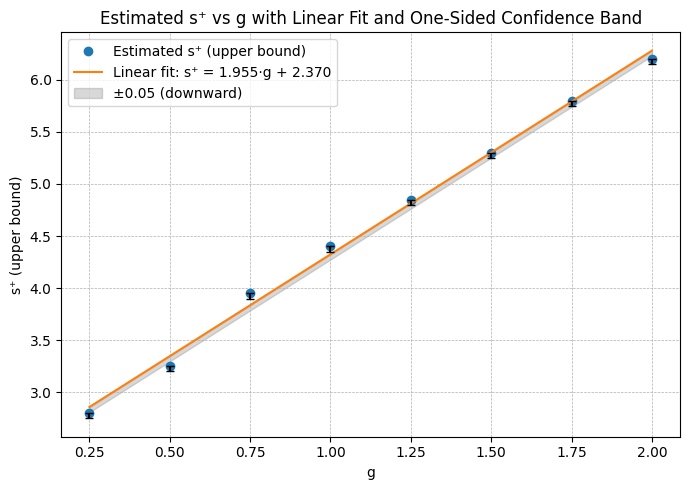

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Data
g = np.array([0.250, 0.500, 0.750, 1.000, 1.250, 1.500, 1.750, 2.000])
s_plus = np.array([2.800, 3.250, 3.950, 4.400, 4.850, 5.300, 5.800, 6.200])
error = 0.05  # one-sided confidence bound

# Linear fit: s⁺ = a*g + b
coeffs = np.polyfit(g, s_plus, 1)
a, b = coeffs
fit_line = np.poly1d(coeffs)
g_fit = np.linspace(min(g), max(g), 200)
s_fit = fit_line(g_fit)

# Compute ±0.025 shaded region (only below, since s⁺ is an upper bound)
lower_band = s_fit - error
upper_band = s_fit  # upper bound

# Plot
plt.figure(figsize=(7, 5))
plt.plot(g, s_plus, "o", label="Estimated s⁺ (upper bound)")
plt.plot(g_fit, s_fit, "-", label=f"Linear fit: s⁺ = {a:.3f}·g + {b:.3f}")
plt.fill_between(g_fit, lower_band, upper_band, color="gray", alpha=0.3, label="±0.05 (downward)")
plt.errorbar(g, s_plus, yerr=[[error]*len(g), [0]*len(g)], fmt='none', ecolor='black', capsize=3)

plt.xlabel("g")
plt.ylabel("s⁺ (upper bound)")
plt.title("Estimated s⁺ vs g with Linear Fit and One-Sided Confidence Band")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


Plot of the Andre's results


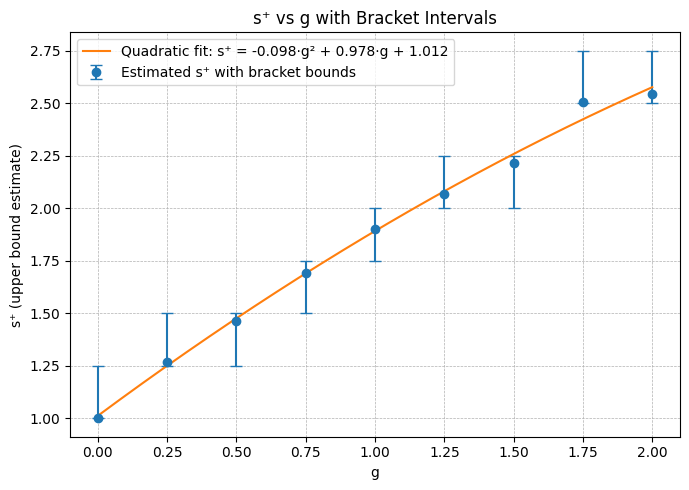

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Data
g = np.array([0.00, 0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00])
s_plus = np.array([1.0039, 1.2695, 1.4648, 1.6914, 1.9023, 2.0664, 2.2148, 2.5039, 2.5430])

# Bracket intervals [low, high] for each s⁺
brackets = np.array([
    [1.000, 1.250],
    [1.250, 1.500],
    [1.250, 1.500],
    [1.500, 1.750],
    [1.750, 2.000],
    [2.000, 2.250],
    [2.000, 2.250],
    [2.500, 2.750],
    [2.500, 2.750],
])

# Compute symmetric errors for plotting
lower_err = s_plus - brackets[:, 0]
upper_err = brackets[:, 1] - s_plus
yerr = np.vstack((lower_err, upper_err))

# Fit a smooth (linear or quadratic) curve
coeffs = np.polyfit(g, s_plus, 2)
fit_curve = np.poly1d(coeffs)
g_fit = np.linspace(min(g), max(g), 200)
s_fit = fit_curve(g_fit)

# Plot
plt.figure(figsize=(7, 5))
plt.errorbar(g, s_plus, yerr=yerr, fmt='o', capsize=4, label="Estimated s⁺ with bracket bounds")
plt.plot(g_fit, s_fit, '-', label=f"Quadratic fit: s⁺ = {coeffs[0]:.3f}·g² + {coeffs[1]:.3f}·g + {coeffs[2]:.3f}")

# Formatting
plt.xlabel("g")
plt.ylabel("s⁺ (upper bound estimate)")
plt.title("s⁺ vs g with Bracket Intervals")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


Now I will try to compute the same thing but the converegence will be computed differently 

In [38]:
# Configurations of the model
T_total      = 200.0        # max simulated time (s)
dt           = 0.05         # integration step
g_list       = [0.5, 1.0, 1.5, 2.0, 2.5]   # random gain (chaos driver)
Ns           = list(range(100, 500, 50))   # network sizes to test
trials_perN  = 20           # how many random (J, x0) trials per N
hold_steps   = 20           # require this many consecutive "quiet" steps
integrator   = "euler"      # "euler" or "heun" (2nd order)
seed_base    = 12345        # base RNG seed (varied per trial)

# Convergence (NEW method): declare converged if ||x_{k+1}-x_k|| < change_tol
# for hold_steps consecutive steps.
change_tol   = 1e-4         # single threshold on the step-to-step change
change_norm  = "l2"         # "l2" or "linf"

# %% [markdown]
# Import all the necessary libraries

# %%
import numpy as np
import matplotlib.pyplot as plt

# %% [markdown]
# Define the necessary utilities

# %%
def rhs(x, s, g, J):
    u = np.tanh(x)
    return -x + s * u + g * (J @ u)

def step_euler(x, s, g, J, dt):
    return x + dt * rhs(x, s, g, J)

def step_heun(x, s, g, J, dt):
    # Predict
    k1 = rhs(x, s, g, J)
    x_pred = x + dt * k1
    # Correct
    k2 = rhs(x_pred, s, g, J)
    return x + 0.5 * dt * (k1 + k2)

# %%
def time_to_convergence(
    N, s, g, *,
    dt=0.05, T_total=200.0,
    change_tol=1e-4,          # NEW: single threshold on ||x_{k+1} - x_k||
    hold_steps=20,            # how many consecutive steps below threshold
    rng=None,
    integrator="euler",
    norm="l2"                 # "l2" or "linf" for the change norm
):
    """
    Returns the first time t where ||x_{k+1}-x_k|| < change_tol for
    'hold_steps' consecutive steps; NaN if not reached within T_total.
    """
    if rng is None:
        rng = np.random.default_rng()

    steps = int(np.ceil(T_total / dt))

    # Random matrix J ~ N(0, 1/N), zero diagonal (self-coupling via 's')
    J = rng.normal(0.0, 1.0 / np.sqrt(N), size=(N, N))
    np.fill_diagonal(J, 0.0)

    # Random initial condition
    x = rng.normal(0.0, 0.1, size=N)

    # Choose integrator
    step_fn = step_heun if integrator == "heun" else step_euler

    def change_norm_fn(dx):
        if norm == "linf":
            return np.max(np.abs(dx))
        return np.linalg.norm(dx)  # default L2

    stable_count = 0
    for k in range(steps):
        x_next = step_fn(x, s, g, J, dt)
        delta = x_next - x
        x = x_next

        if change_norm_fn(delta) < change_tol:
            stable_count += 1
        else:
            stable_count = 0

        if stable_count >= hold_steps:
            return (k + 1) * dt

    return np.nan  # not converged within T_total

# %%
def run_scaling_experiment(
    Ns, s, g, trials_perN, *,
    dt, T_total,
    change_tol, hold_steps,
    seed_base=12345, integrator="euler", norm="l2"
):
    """
    Run multiple trials over Ns and return a dict: {N: {'taus', 'valid', 'censored'}}.
    """
    results = {}
    for i, N in enumerate(Ns):
        taus = []
        for t in range(trials_perN):
            rng = np.random.default_rng(seed_base + 100000 * i + t)
            tau = time_to_convergence(
                N, s, g,
                dt=dt, T_total=T_total,
                change_tol=change_tol, hold_steps=hold_steps,
                rng=rng, integrator=integrator, norm=norm
            )
            taus.append(tau)
        taus = np.array(taus, dtype=float)
        results[N] = {
            "taus": taus,
            "valid": np.isfinite(taus).sum(),
            "censored": np.isnan(taus).sum()
        }
    return results

# %% [markdown]
# Classifier: Fast (polynomial) vs Slow (exponential) scaling

# %%
def is_fast_convergence(N, T, bic_margin=5.0, min_points=3):
    """
    Returns True if convergence is fast (polynomial scaling), False if slow (exponential).
    N: list/array of network sizes
    T: list/array of summary convergence times (e.g., medians per N)
    """
    N = np.asarray(N, dtype=float)
    T = np.asarray(T, dtype=float)

    # Filter invalid points
    ok = (N > 0) & np.isfinite(T) & (T > 0)
    N, T = N[ok], T[ok]
    if len(N) < min_points:
        return False  # Not enough data

    logT = np.log(T)
    logN = np.log(N)

    # Linear fits for both models
    def linfit(x, y):
        x_mean, y_mean = np.mean(x), np.mean(y)
        x_var = np.mean((x - x_mean)**2)
        if x_var == 0:
            return 0.0, y_mean, np.inf
        a = np.mean((x - x_mean)*(y - y_mean)) / x_var
        b = y_mean - a*x_mean
        sse = np.sum((y - (a*x + b))**2)
        return a, b, sse

    def bic(n, sse, k=2):
        if n <= k or sse <= 0:
            return np.inf
        return n * np.log(sse/n) + k * np.log(n)

    # Exponential model: log(T) ~ a*N + b
    _, _, sse_exp = linfit(N, logT)
    bic_exp = bic(len(N), sse_exp)

    # Polynomial model: log(T) ~ k*log(N) + c
    _, _, sse_poly = linfit(logN, logT)
    bic_poly = bic(len(N), sse_poly)

    # Compare BICs
    return (bic_poly + bic_margin) < bic_exp

# %%
def summarize_times(results, reducer="median"):
    """Turn {N: {'taus': ...}} into aligned arrays (Ns_sorted, T_summary)."""
    Ns_sorted = np.array(sorted(results.keys()), dtype=float)
    T_summary = []
    for N in Ns_sorted:
        taus = results[N]["taus"]
        vals = taus[np.isfinite(taus)]
        if len(vals) == 0:
            T_summary.append(np.nan)
        else:
            if reducer == "median":
                T_summary.append(np.median(vals))
            elif reducer == "mean":
                T_summary.append(np.mean(vals))
            else:
                raise ValueError("Unknown reducer")
    return Ns_sorted, np.array(T_summary, dtype=float)

# %%
def find_s_threshold(
    g,
    s_start,
    s_stop,
    s_step=0.05,
    Ns_scan=None,
    trials_perN_scan=None,
    *,
    dt=dt, T_total=T_total,
    change_tol=change_tol, hold_steps=hold_steps,
    seed_base=seed_base, integrator=integrator, norm=change_norm,
    bic_margin=5.0, min_points=3, reducer="median"
):
    """
    Scan s in [s_start, s_stop] and return the first s where scaling is 'fast'.
    Returns np.nan if not found.
    """
    if Ns_scan is None:
        Ns_scan = Ns
    if trials_perN_scan is None:
        trials_perN_scan = trials_perN

    s_values = np.arange(s_start, s_stop + 1e-12, s_step, dtype=float)

    for s in s_values:
        results = run_scaling_experiment(
            Ns_scan, s, g,
            trials_perN=trials_perN_scan,
            dt=dt, T_total=T_total,
            change_tol=change_tol, hold_steps=hold_steps,
            seed_base=seed_base, integrator=integrator, norm=norm
        )
        Ns_arr, T_arr = summarize_times(results, reducer=reducer)

        if is_fast_convergence(Ns_arr, T_arr, bic_margin=bic_margin, min_points=min_points):
            print(f"For g = {g:.3f}, s⁺ ≈ {s:.3f} (fast scaling detected)")
            return float(s)

    print(f"No fast-scaling transition found for g = {g:.3f} in [{s_start}, {s_stop}]")
    return np.nan

# %%
def sweep_s_plus_over_g(
    g_values,
    s0=1.0,
    s_window=2.0,
    s_step=0.05,
    Ns_scan=None,
    trials_perN_scan=None,
    **kwargs
):
    """
    For each g, search s in [s_prev, s_prev + s_window] starting at s_prev,
    where s_prev starts at s0 and then updates to the last found s⁺(g).
    """
    s_thresholds = []
    s_prev = float(s0)
    for g in g_values:
        s_plus = find_s_threshold(
            g=g,
            s_start=s_prev,
            s_stop=s_prev + s_window,
            s_step=s_step,
            Ns_scan=Ns_scan,
            trials_perN_scan=trials_perN_scan,
            **kwargs
        )
        s_thresholds.append((g, s_plus))
        if np.isfinite(s_plus):
            s_prev = s_plus
    return s_thresholds

# %% [markdown]
# Example usage (WARNING: can be heavy—reduce Ns/trials for a quick test)

# %%
#Quick sanity run (lightweight):
# Ns_quick = list(range(100, 251, 50))
# thresholds_quick = sweep_s_plus_over_g(
#     g_values=[0.5, 1.0],
#     s0=1.0, s_window=3.0, s_step=0.25,
#     Ns_scan=Ns_quick, trials_perN_scan=20,
#     dt=dt, T_total=T_total,
#     change_tol=1e-3, hold_steps=hold_steps,
#     seed_base=seed_base, integrator=integrator, norm=change_norm,
#     bic_margin=5.0, min_points=3, reducer="median"
# )
# print("Quick thresholds:", thresholds_quick)

# Full sweep (uncomment to run):
thresholds = sweep_s_plus_over_g(
     g_values=(0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0),
     s0=1.1, s_window=2.0, s_step=0.05,
     Ns_scan=Ns, trials_perN_scan=20,
     dt=dt, T_total=T_total,
     change_tol=1e-3, hold_steps=hold_steps,
     seed_base=seed_base, integrator=integrator, norm=change_norm,
     bic_margin=5.0, min_points=3, reducer="median"
)
print("Thresholds:", thresholds)


For g = 0.250, s⁺ ≈ 2.150 (fast scaling detected)
For g = 0.500, s⁺ ≈ 3.050 (fast scaling detected)
For g = 0.750, s⁺ ≈ 3.450 (fast scaling detected)
For g = 1.000, s⁺ ≈ 3.950 (fast scaling detected)
For g = 1.250, s⁺ ≈ 4.500 (fast scaling detected)
For g = 1.500, s⁺ ≈ 4.900 (fast scaling detected)
For g = 1.750, s⁺ ≈ 5.050 (fast scaling detected)
For g = 2.000, s⁺ ≈ 5.700 (fast scaling detected)
Thresholds: [(0.25, 2.1500000000000012), (0.5, 3.049999999999998), (0.75, 3.4499999999999966), (1.0, 3.949999999999995), (1.25, 4.499999999999993), (1.5, 4.8999999999999915), (1.75, 5.049999999999991), (2.0, 5.699999999999989)]


And the plot for these results is this 

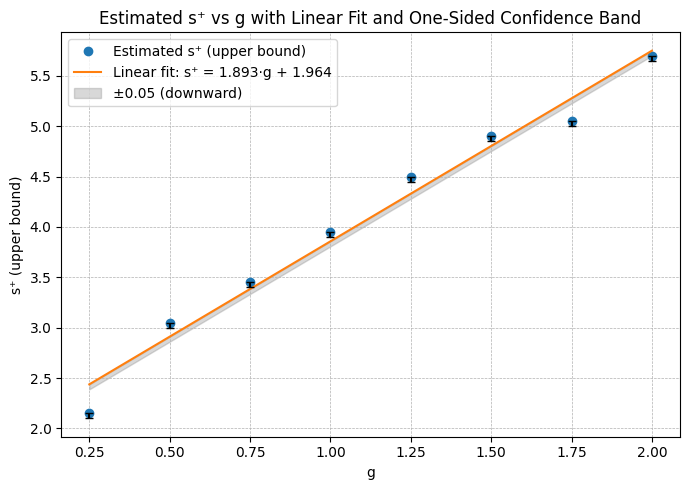

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Data
g = np.array([0.250, 0.500, 0.750, 1.000, 1.250, 1.500, 1.750, 2.000])
s_plus = np.array([2.150, 3.050, 3.450, 3.950, 4.500, 4.900, 5.050, 5.700])
error = 0.05  # one-sided confidence bound

# Linear fit: s⁺ = a*g + b
coeffs = np.polyfit(g, s_plus, 1)
a, b = coeffs
fit_line = np.poly1d(coeffs)
g_fit = np.linspace(min(g), max(g), 200)
s_fit = fit_line(g_fit)

# Compute ±0.025 shaded region (only below, since s⁺ is an upper bound)
lower_band = s_fit - error
upper_band = s_fit  # upper bound

# Plot
plt.figure(figsize=(7, 5))
plt.plot(g, s_plus, "o", label="Estimated s⁺ (upper bound)")
plt.plot(g_fit, s_fit, "-", label=f"Linear fit: s⁺ = {a:.3f}·g + {b:.3f}")
plt.fill_between(g_fit, lower_band, upper_band, color="gray", alpha=0.3, label="±0.05 (downward)")
plt.errorbar(g, s_plus, yerr=[[error]*len(g), [0]*len(g)], fmt='none', ecolor='black', capsize=3)

plt.xlabel("g")
plt.ylabel("s⁺ (upper bound)")
plt.title("Estimated s⁺ vs g with Linear Fit and One-Sided Confidence Band")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

I would assume that this is because the interval for which this is computed is quite big and more and more it is going to become closer to the results of mine. Below are simulations with lower bounds 
P.s. I start from 2.150 as it is bounded by the upper example

In [39]:
# Configurations of the model
T_total      = 200.0        # max simulated time (s)
dt           = 0.05         # integration step
g_list       = [0.5, 1.0, 1.5, 2.0, 2.5]   # random gain (chaos driver)
Ns           = list(range(100, 500, 50))   # network sizes to test
trials_perN  = 20           # how many random (J, x0) trials per N
hold_steps   = 20           # require this many consecutive "quiet" steps
integrator   = "euler"      # "euler" or "heun" (2nd order)
seed_base    = 12345        # base RNG seed (varied per trial)

# Convergence (NEW method): declare converged if ||x_{k+1}-x_k|| < change_tol
# for hold_steps consecutive steps.
change_tol   = 1e-4         # single threshold on the step-to-step change
change_norm  = "l2"         # "l2" or "linf"

# %% [markdown]
# Import all the necessary libraries

# %%
import numpy as np
import matplotlib.pyplot as plt

# %% [markdown]
# Define the necessary utilities

# %%
def rhs(x, s, g, J):
    u = np.tanh(x)
    return -x + s * u + g * (J @ u)

def step_euler(x, s, g, J, dt):
    return x + dt * rhs(x, s, g, J)

def step_heun(x, s, g, J, dt):
    # Predict
    k1 = rhs(x, s, g, J)
    x_pred = x + dt * k1
    # Correct
    k2 = rhs(x_pred, s, g, J)
    return x + 0.5 * dt * (k1 + k2)

# %%
def time_to_convergence(
    N, s, g, *,
    dt=0.05, T_total=200.0,
    change_tol=1e-4,          # NEW: single threshold on ||x_{k+1} - x_k||
    hold_steps=20,            # how many consecutive steps below threshold
    rng=None,
    integrator="euler",
    norm="l2"                 # "l2" or "linf" for the change norm
):
    """
    Returns the first time t where ||x_{k+1}-x_k|| < change_tol for
    'hold_steps' consecutive steps; NaN if not reached within T_total.
    """
    if rng is None:
        rng = np.random.default_rng()

    steps = int(np.ceil(T_total / dt))

    # Random matrix J ~ N(0, 1/N), zero diagonal (self-coupling via 's')
    J = rng.normal(0.0, 1.0 / np.sqrt(N), size=(N, N))
    np.fill_diagonal(J, 0.0)

    # Random initial condition
    x = rng.normal(0.0, 0.1, size=N)

    # Choose integrator
    step_fn = step_heun if integrator == "heun" else step_euler

    def change_norm_fn(dx):
        if norm == "linf":
            return np.max(np.abs(dx))
        return np.linalg.norm(dx)  # default L2

    stable_count = 0
    for k in range(steps):
        x_next = step_fn(x, s, g, J, dt)
        delta = x_next - x
        x = x_next

        if change_norm_fn(delta) < change_tol:
            stable_count += 1
        else:
            stable_count = 0

        if stable_count >= hold_steps:
            return (k + 1) * dt

    return np.nan  # not converged within T_total

# %%
def run_scaling_experiment(
    Ns, s, g, trials_perN, *,
    dt, T_total,
    change_tol, hold_steps,
    seed_base=12345, integrator="euler", norm="l2"
):
    """
    Run multiple trials over Ns and return a dict: {N: {'taus', 'valid', 'censored'}}.
    """
    results = {}
    for i, N in enumerate(Ns):
        taus = []
        for t in range(trials_perN):
            rng = np.random.default_rng(seed_base + 100000 * i + t)
            tau = time_to_convergence(
                N, s, g,
                dt=dt, T_total=T_total,
                change_tol=change_tol, hold_steps=hold_steps,
                rng=rng, integrator=integrator, norm=norm
            )
            taus.append(tau)
        taus = np.array(taus, dtype=float)
        results[N] = {
            "taus": taus,
            "valid": np.isfinite(taus).sum(),
            "censored": np.isnan(taus).sum()
        }
    return results

# %% [markdown]
# Classifier: Fast (polynomial) vs Slow (exponential) scaling

# %%
def is_fast_convergence(N, T, bic_margin=5.0, min_points=3):
    """
    Returns True if convergence is fast (polynomial scaling), False if slow (exponential).
    N: list/array of network sizes
    T: list/array of summary convergence times (e.g., medians per N)
    """
    N = np.asarray(N, dtype=float)
    T = np.asarray(T, dtype=float)

    # Filter invalid points
    ok = (N > 0) & np.isfinite(T) & (T > 0)
    N, T = N[ok], T[ok]
    if len(N) < min_points:
        return False  # Not enough data

    logT = np.log(T)
    logN = np.log(N)

    # Linear fits for both models
    def linfit(x, y):
        x_mean, y_mean = np.mean(x), np.mean(y)
        x_var = np.mean((x - x_mean)**2)
        if x_var == 0:
            return 0.0, y_mean, np.inf
        a = np.mean((x - x_mean)*(y - y_mean)) / x_var
        b = y_mean - a*x_mean
        sse = np.sum((y - (a*x + b))**2)
        return a, b, sse

    def bic(n, sse, k=2):
        if n <= k or sse <= 0:
            return np.inf
        return n * np.log(sse/n) + k * np.log(n)

    # Exponential model: log(T) ~ a*N + b
    _, _, sse_exp = linfit(N, logT)
    bic_exp = bic(len(N), sse_exp)

    # Polynomial model: log(T) ~ k*log(N) + c
    _, _, sse_poly = linfit(logN, logT)
    bic_poly = bic(len(N), sse_poly)

    # Compare BICs
    return (bic_poly + bic_margin) < bic_exp

# %%
def summarize_times(results, reducer="median"):
    """Turn {N: {'taus': ...}} into aligned arrays (Ns_sorted, T_summary)."""
    Ns_sorted = np.array(sorted(results.keys()), dtype=float)
    T_summary = []
    for N in Ns_sorted:
        taus = results[N]["taus"]
        vals = taus[np.isfinite(taus)]
        if len(vals) == 0:
            T_summary.append(np.nan)
        else:
            if reducer == "median":
                T_summary.append(np.median(vals))
            elif reducer == "mean":
                T_summary.append(np.mean(vals))
            else:
                raise ValueError("Unknown reducer")
    return Ns_sorted, np.array(T_summary, dtype=float)

# %%
def find_s_threshold(
    g,
    s_start,
    s_stop,
    s_step=0.05,
    Ns_scan=None,
    trials_perN_scan=None,
    *,
    dt=dt, T_total=T_total,
    change_tol=change_tol, hold_steps=hold_steps,
    seed_base=seed_base, integrator=integrator, norm=change_norm,
    bic_margin=5.0, min_points=3, reducer="median"
):
    """
    Scan s in [s_start, s_stop] and return the first s where scaling is 'fast'.
    Returns np.nan if not found.
    """
    if Ns_scan is None:
        Ns_scan = Ns
    if trials_perN_scan is None:
        trials_perN_scan = trials_perN

    s_values = np.arange(s_start, s_stop + 1e-12, s_step, dtype=float)

    for s in s_values:
        results = run_scaling_experiment(
            Ns_scan, s, g,
            trials_perN=trials_perN_scan,
            dt=dt, T_total=T_total,
            change_tol=change_tol, hold_steps=hold_steps,
            seed_base=seed_base, integrator=integrator, norm=norm
        )
        Ns_arr, T_arr = summarize_times(results, reducer=reducer)

        if is_fast_convergence(Ns_arr, T_arr, bic_margin=bic_margin, min_points=min_points):
            print(f"For g = {g:.3f}, s⁺ ≈ {s:.3f} (fast scaling detected)")
            return float(s)

    print(f"No fast-scaling transition found for g = {g:.3f} in [{s_start}, {s_stop}]")
    return np.nan

# %%
def sweep_s_plus_over_g(
    g_values,
    s0=1.0,
    s_window=2.0,
    s_step=0.05,
    Ns_scan=None,
    trials_perN_scan=None,
    **kwargs
):
    """
    For each g, search s in [s_prev, s_prev + s_window] starting at s_prev,
    where s_prev starts at s0 and then updates to the last found s⁺(g).
    """
    s_thresholds = []
    s_prev = float(s0)
    for g in g_values:
        s_plus = find_s_threshold(
            g=g,
            s_start=s_prev,
            s_stop=s_prev + s_window,
            s_step=s_step,
            Ns_scan=Ns_scan,
            trials_perN_scan=trials_perN_scan,
            **kwargs
        )
        s_thresholds.append((g, s_plus))
        if np.isfinite(s_plus):
            s_prev = s_plus
    return s_thresholds

# %% [markdown]
# Example usage (WARNING: can be heavy—reduce Ns/trials for a quick test)

# %%
#Quick sanity run (lightweight):
# Ns_quick = list(range(100, 251, 50))
# thresholds_quick = sweep_s_plus_over_g(
#     g_values=[0.5, 1.0],
#     s0=1.0, s_window=3.0, s_step=0.25,
#     Ns_scan=Ns_quick, trials_perN_scan=20,
#     dt=dt, T_total=T_total,
#     change_tol=1e-3, hold_steps=hold_steps,
#     seed_base=seed_base, integrator=integrator, norm=change_norm,
#     bic_margin=5.0, min_points=3, reducer="median"
# )
# print("Quick thresholds:", thresholds_quick)

# Full sweep (uncomment to run):
thresholds = sweep_s_plus_over_g(
     g_values=(0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0),
     s0=2.15, s_window=2.0, s_step=0.05,
     Ns_scan=Ns, trials_perN_scan=20,
     dt=dt, T_total=T_total,
     change_tol=1e-6, hold_steps=hold_steps,
     seed_base=seed_base, integrator=integrator, norm=change_norm,
     bic_margin=5.0, min_points=3, reducer="median"
)
print("Thresholds:", thresholds)

For g = 0.250, s⁺ ≈ 2.800 (fast scaling detected)
For g = 0.500, s⁺ ≈ 3.150 (fast scaling detected)
For g = 0.750, s⁺ ≈ 3.600 (fast scaling detected)
For g = 1.000, s⁺ ≈ 4.150 (fast scaling detected)
For g = 1.250, s⁺ ≈ 4.800 (fast scaling detected)
For g = 1.500, s⁺ ≈ 5.300 (fast scaling detected)
For g = 1.750, s⁺ ≈ 5.800 (fast scaling detected)
For g = 2.000, s⁺ ≈ 6.200 (fast scaling detected)
Thresholds: [(0.25, 2.7999999999999976), (0.5, 3.1499999999999964), (0.75, 3.5999999999999948), (1.0, 4.149999999999993), (1.25, 4.799999999999991), (1.5, 5.299999999999989), (1.75, 5.799999999999987), (2.0, 6.199999999999986)]


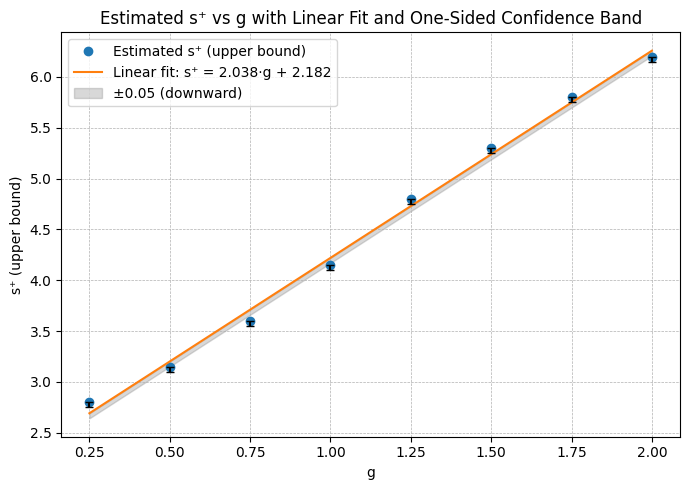

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Data
g = np.array([0.250, 0.500, 0.750, 1.000, 1.250, 1.500, 1.750, 2.000])
s_plus = np.array([2.8, 3.150, 3.60, 4.150, 4.800, 5.300, 5.80, 6.200])
error = 0.05  # one-sided confidence bound

# Linear fit: s⁺ = a*g + b
coeffs = np.polyfit(g, s_plus, 1)
a, b = coeffs
fit_line = np.poly1d(coeffs)
g_fit = np.linspace(min(g), max(g), 200)
s_fit = fit_line(g_fit)

# Compute ±0.025 shaded region (only below, since s⁺ is an upper bound)
lower_band = s_fit - error
upper_band = s_fit  # upper bound

# Plot
plt.figure(figsize=(7, 5))
plt.plot(g, s_plus, "o", label="Estimated s⁺ (upper bound)")
plt.plot(g_fit, s_fit, "-", label=f"Linear fit: s⁺ = {a:.3f}·g + {b:.3f}")
plt.fill_between(g_fit, lower_band, upper_band, color="gray", alpha=0.3, label="±0.05 (downward)")
plt.errorbar(g, s_plus, yerr=[[error]*len(g), [0]*len(g)], fmt='none', ecolor='black', capsize=3)

plt.xlabel("g")
plt.ylabel("s⁺ (upper bound)")
plt.title("Estimated s⁺ vs g with Linear Fit and One-Sided Confidence Band")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# Configurations of the model
T_total      = 200.0        # max simulated time (s)
dt           = 0.05         # integration step
g_list       = [0.5, 1.0, 1.5, 2.0, 2.5]   # random gain (chaos driver)
Ns           = list(range(100, 500, 50))   # network sizes to test
trials_perN  = 20           # how many random (J, x0) trials per N
hold_steps   = 20           # require this many consecutive "quiet" steps
integrator   = "euler"      # "euler" or "heun" (2nd order)
seed_base    = 12345        # base RNG seed (varied per trial)

# Convergence (NEW method): declare converged if ||x_{k+1}-x_k|| < change_tol
# for hold_steps consecutive steps.
change_tol   = 1e-4         # single threshold on the step-to-step change
change_norm  = "l2"         # "l2" or "linf"

# %% [markdown]
# Import all the necessary libraries

# %%
import numpy as np
import matplotlib.pyplot as plt

# %% [markdown]
# Define the necessary utilities

# %%
def rhs(x, s, g, J):
    u = np.tanh(x)
    return -x + s * u + g * (J @ u)

def step_euler(x, s, g, J, dt):
    return x + dt * rhs(x, s, g, J)

def step_heun(x, s, g, J, dt):
    # Predict
    k1 = rhs(x, s, g, J)
    x_pred = x + dt * k1
    # Correct
    k2 = rhs(x_pred, s, g, J)
    return x + 0.5 * dt * (k1 + k2)

# %%
def time_to_convergence(
    N, s, g, *,
    dt=0.05, T_total=200.0,
    change_tol=1e-4,          # NEW: single threshold on ||x_{k+1} - x_k||
    hold_steps=20,            # how many consecutive steps below threshold
    rng=None,
    integrator="euler",
    norm="l2"                 # "l2" or "linf" for the change norm
):
    """
    Returns the first time t where ||x_{k+1}-x_k|| < change_tol for
    'hold_steps' consecutive steps; NaN if not reached within T_total.
    """
    if rng is None:
        rng = np.random.default_rng()

    steps = int(np.ceil(T_total / dt))

    # Random matrix J ~ N(0, 1/N), zero diagonal (self-coupling via 's')
    J = rng.normal(0.0, 1.0 / np.sqrt(N), size=(N, N))
    np.fill_diagonal(J, 0.0)

    # Random initial condition
    x = rng.normal(0.0, 0.1, size=N)

    # Choose integrator
    step_fn = step_heun if integrator == "heun" else step_euler

    def change_norm_fn(dx):
        if norm == "linf":
            return np.max(np.abs(dx))
        return np.linalg.norm(dx)  # default L2

    stable_count = 0
    for k in range(steps):
        x_next = step_fn(x, s, g, J, dt)
        delta = x_next - x
        x = x_next

        if change_norm_fn(delta) < change_tol:
            stable_count += 1
        else:
            stable_count = 0

        if stable_count >= hold_steps:
            return (k + 1) * dt

    return np.nan  # not converged within T_total

# %%
def run_scaling_experiment(
    Ns, s, g, trials_perN, *,
    dt, T_total,
    change_tol, hold_steps,
    seed_base=12345, integrator="euler", norm="l2"
):
    """
    Run multiple trials over Ns and return a dict: {N: {'taus', 'valid', 'censored'}}.
    """
    results = {}
    for i, N in enumerate(Ns):
        taus = []
        for t in range(trials_perN):
            rng = np.random.default_rng(seed_base + 100000 * i + t)
            tau = time_to_convergence(
                N, s, g,
                dt=dt, T_total=T_total,
                change_tol=change_tol, hold_steps=hold_steps,
                rng=rng, integrator=integrator, norm=norm
            )
            taus.append(tau)
        taus = np.array(taus, dtype=float)
        results[N] = {
            "taus": taus,
            "valid": np.isfinite(taus).sum(),
            "censored": np.isnan(taus).sum()
        }
    return results

# %% [markdown]
# Classifier: Fast (polynomial) vs Slow (exponential) scaling

# %%
def is_fast_convergence(N, T, bic_margin=5.0, min_points=3):
    """
    Returns True if convergence is fast (polynomial scaling), False if slow (exponential).
    N: list/array of network sizes
    T: list/array of summary convergence times (e.g., medians per N)
    """
    N = np.asarray(N, dtype=float)
    T = np.asarray(T, dtype=float)

    # Filter invalid points
    ok = (N > 0) & np.isfinite(T) & (T > 0)
    N, T = N[ok], T[ok]
    if len(N) < min_points:
        return False  # Not enough data

    logT = np.log(T)
    logN = np.log(N)

    # Linear fits for both models
    def linfit(x, y):
        x_mean, y_mean = np.mean(x), np.mean(y)
        x_var = np.mean((x - x_mean)**2)
        if x_var == 0:
            return 0.0, y_mean, np.inf
        a = np.mean((x - x_mean)*(y - y_mean)) / x_var
        b = y_mean - a*x_mean
        sse = np.sum((y - (a*x + b))**2)
        return a, b, sse

    def bic(n, sse, k=2):
        if n <= k or sse <= 0:
            return np.inf
        return n * np.log(sse/n) + k * np.log(n)

    # Exponential model: log(T) ~ a*N + b
    _, _, sse_exp = linfit(N, logT)
    bic_exp = bic(len(N), sse_exp)

    # Polynomial model: log(T) ~ k*log(N) + c
    _, _, sse_poly = linfit(logN, logT)
    bic_poly = bic(len(N), sse_poly)

    # Compare BICs
    return (bic_poly + bic_margin) < bic_exp

# %%
def summarize_times(results, reducer="median"):
    """Turn {N: {'taus': ...}} into aligned arrays (Ns_sorted, T_summary)."""
    Ns_sorted = np.array(sorted(results.keys()), dtype=float)
    T_summary = []
    for N in Ns_sorted:
        taus = results[N]["taus"]
        vals = taus[np.isfinite(taus)]
        if len(vals) == 0:
            T_summary.append(np.nan)
        else:
            if reducer == "median":
                T_summary.append(np.median(vals))
            elif reducer == "mean":
                T_summary.append(np.mean(vals))
            else:
                raise ValueError("Unknown reducer")
    return Ns_sorted, np.array(T_summary, dtype=float)

# %%
def find_s_threshold(
    g,
    s_start,
    s_stop,
    s_step=0.05,
    Ns_scan=None,
    trials_perN_scan=None,
    *,
    dt=dt, T_total=T_total,
    change_tol=change_tol, hold_steps=hold_steps,
    seed_base=seed_base, integrator=integrator, norm=change_norm,
    bic_margin=5.0, min_points=3, reducer="median"
):
    """
    Scan s in [s_start, s_stop] and return the first s where scaling is 'fast'.
    Returns np.nan if not found.
    """
    if Ns_scan is None:
        Ns_scan = Ns
    if trials_perN_scan is None:
        trials_perN_scan = trials_perN

    s_values = np.arange(s_start, s_stop + 1e-12, s_step, dtype=float)

    for s in s_values:
        results = run_scaling_experiment(
            Ns_scan, s, g,
            trials_perN=trials_perN_scan,
            dt=dt, T_total=T_total,
            change_tol=change_tol, hold_steps=hold_steps,
            seed_base=seed_base, integrator=integrator, norm=norm
        )
        Ns_arr, T_arr = summarize_times(results, reducer=reducer)

        if is_fast_convergence(Ns_arr, T_arr, bic_margin=bic_margin, min_points=min_points):
            print(f"For g = {g:.3f}, s⁺ ≈ {s:.3f} (fast scaling detected)")
            return float(s)

    print(f"No fast-scaling transition found for g = {g:.3f} in [{s_start}, {s_stop}]")
    return np.nan

# %%
def sweep_s_plus_over_g(
    g_values,
    s0=1.0,
    s_window=2.0,
    s_step=0.05,
    Ns_scan=None,
    trials_perN_scan=None,
    **kwargs
):
    """
    For each g, search s in [s_prev, s_prev + s_window] starting at s_prev,
    where s_prev starts at s0 and then updates to the last found s⁺(g).
    """
    s_thresholds = []
    s_prev = float(s0)
    for g in g_values:
        s_plus = find_s_threshold(
            g=g,
            s_start=s_prev,
            s_stop=s_prev + s_window,
            s_step=s_step,
            Ns_scan=Ns_scan,
            trials_perN_scan=trials_perN_scan,
            **kwargs
        )
        s_thresholds.append((g, s_plus))
        if np.isfinite(s_plus):
            s_prev = s_plus
    return s_thresholds

# %% [markdown]
# Example usage (WARNING: can be heavy—reduce Ns/trials for a quick test)

# %%
#Quick sanity run (lightweight):
# Ns_quick = list(range(100, 251, 50))
# thresholds_quick = sweep_s_plus_over_g(
#     g_values=[0.5, 1.0],
#     s0=1.0, s_window=3.0, s_step=0.25,
#     Ns_scan=Ns_quick, trials_perN_scan=20,
#     dt=dt, T_total=T_total,
#     change_tol=1e-3, hold_steps=hold_steps,
#     seed_base=seed_base, integrator=integrator, norm=change_norm,
#     bic_margin=5.0, min_points=3, reducer="median"
# )
# print("Quick thresholds:", thresholds_quick)

# Full sweep (uncomment to run):
thresholds = sweep_s_plus_over_g(
     g_values=(0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0),
     s0=2.8, s_window=2.0, s_step=0.05,
     Ns_scan=Ns, trials_perN_scan=20,
     dt=dt, T_total=T_total,
     change_tol=1e-12, hold_steps=hold_steps,
     seed_base=seed_base, integrator=integrator, norm=change_norm,
     bic_margin=5.0, min_points=3, reducer="median"
)
print("Thresholds:", thresholds)

For g = 0.250, s⁺ ≈ 2.800 (fast scaling detected)
For g = 0.500, s⁺ ≈ 3.700 (fast scaling detected)
For g = 0.750, s⁺ ≈ 4.250 (fast scaling detected)
For g = 1.000, s⁺ ≈ 4.950 (fast scaling detected)
For g = 1.250, s⁺ ≈ 5.500 (fast scaling detected)
For g = 1.500, s⁺ ≈ 5.500 (fast scaling detected)
For g = 1.750, s⁺ ≈ 6.200 (fast scaling detected)
For g = 2.000, s⁺ ≈ 6.850 (fast scaling detected)
Thresholds: [(0.25, 2.8), (0.5, 3.6999999999999966), (0.75, 4.249999999999995), (1.0, 4.949999999999992), (1.25, 5.49999999999999), (1.5, 5.49999999999999), (1.75, 6.199999999999988), (2.0, 6.849999999999985)]


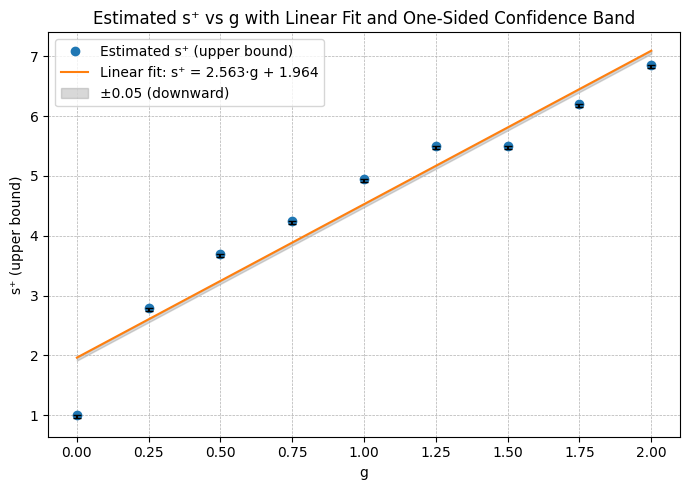

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Data
g = np.array([0,0.250, 0.500, 0.750, 1.000, 1.250, 1.500, 1.750, 2.000])
s_plus = np.array([1,2.8, 3.7, 4.25, 4.950, 5.5, 5.500, 6.200,6.85])
error = 0.05  # one-sided confidence bound

# Linear fit: s⁺ = a*g + b
coeffs = np.polyfit(g, s_plus, 1)
a, b = coeffs
fit_line = np.poly1d(coeffs)
g_fit = np.linspace(min(g), max(g), 200)
s_fit = fit_line(g_fit)

# Compute ±0.025 shaded region (only below, since s⁺ is an upper bound)
lower_band = s_fit - error
upper_band = s_fit  # upper bound

# Plot
plt.figure(figsize=(7, 5))
plt.plot(g, s_plus, "o", label="Estimated s⁺ (upper bound)")
plt.plot(g_fit, s_fit, "-", label=f"Linear fit: s⁺ = {a:.3f}·g + {b:.3f}")
plt.fill_between(g_fit, lower_band, upper_band, color="gray", alpha=0.3, label="±0.05 (downward)")
plt.errorbar(g, s_plus, yerr=[[error]*len(g), [0]*len(g)], fmt='none', ecolor='black', capsize=3)

plt.xlabel("g")
plt.ylabel("s⁺ (upper bound)")
plt.title("Estimated s⁺ vs g with Linear Fit and One-Sided Confidence Band")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

In [46]:
# Configurations of the model
T_total      = 200.0        # max simulated time (s)
dt           = 0.05         # integration step
g_list       = [0.5, 1.0, 1.5, 2.0, 2.5]   # random gain (chaos driver)
Ns           = list(range(100, 500, 50))   # network sizes to test
trials_perN  = 20           # how many random (J, x0) trials per N
hold_steps   = 20           # require this many consecutive "quiet" steps
integrator   = "euler"      # "euler" or "heun" (2nd order)
seed_base    = 12345        # base RNG seed (varied per trial)

# Convergence (NEW method): declare converged if ||x_{k+1}-x_k|| < change_tol
# for hold_steps consecutive steps.
change_tol   = 1e-4         # single threshold on the step-to-step change
change_norm  = "l2"         # "l2" or "linf"

# %% [markdown]
# Import all the necessary libraries

# %%
import numpy as np
import matplotlib.pyplot as plt

# %% [markdown]
# Define the necessary utilities

# %%
def rhs(x, s, g, J):
    u = np.tanh(x)
    return -x + s * u + g * (J @ u)

def step_euler(x, s, g, J, dt):
    return x + dt * rhs(x, s, g, J)

def step_heun(x, s, g, J, dt):
    # Predict
    k1 = rhs(x, s, g, J)
    x_pred = x + dt * k1
    # Correct
    k2 = rhs(x_pred, s, g, J)
    return x + 0.5 * dt * (k1 + k2)

# %%
def time_to_convergence(
    N, s, g, *,
    dt=0.05, T_total=200.0,
    change_tol=1e-4,          # NEW: single threshold on ||x_{k+1} - x_k||
    hold_steps=20,            # how many consecutive steps below threshold
    rng=None,
    integrator="euler",
    norm="l2"                 # "l2" or "linf" for the change norm
):
    """
    Returns the first time t where ||x_{k+1}-x_k|| < change_tol for
    'hold_steps' consecutive steps; NaN if not reached within T_total.
    """
    if rng is None:
        rng = np.random.default_rng()

    steps = int(np.ceil(T_total / dt))

    # Random matrix J ~ N(0, 1/N), zero diagonal (self-coupling via 's')
    J = rng.normal(0.0, 1.0 / np.sqrt(N), size=(N, N))
    np.fill_diagonal(J, 0.0)

    # Random initial condition
    x = rng.normal(0.0, 0.1, size=N)

    # Choose integrator
    step_fn = step_heun if integrator == "heun" else step_euler

    def change_norm_fn(dx):
        if norm == "linf":
            return np.max(np.abs(dx))
        return np.linalg.norm(dx)  # default L2

    stable_count = 0
    for k in range(steps):
        x_next = step_fn(x, s, g, J, dt)
        delta = x_next - x
        x = x_next

        if change_norm_fn(delta) < change_tol:
            stable_count += 1
        else:
            stable_count = 0

        if stable_count >= hold_steps:
            return (k + 1) * dt

    return np.nan  # not converged within T_total

# %%
def run_scaling_experiment(
    Ns, s, g, trials_perN, *,
    dt, T_total,
    change_tol, hold_steps,
    seed_base=12345, integrator="euler", norm="l2"
):
    """
    Run multiple trials over Ns and return a dict: {N: {'taus', 'valid', 'censored'}}.
    """
    results = {}
    for i, N in enumerate(Ns):
        taus = []
        for t in range(trials_perN):
            rng = np.random.default_rng(seed_base + 100000 * i + t)
            tau = time_to_convergence(
                N, s, g,
                dt=dt, T_total=T_total,
                change_tol=change_tol, hold_steps=hold_steps,
                rng=rng, integrator=integrator, norm=norm
            )
            taus.append(tau)
        taus = np.array(taus, dtype=float)
        results[N] = {
            "taus": taus,
            "valid": np.isfinite(taus).sum(),
            "censored": np.isnan(taus).sum()
        }
    return results

# %% [markdown]
# Classifier: Fast (polynomial) vs Slow (exponential) scaling

# %%
def is_fast_convergence(N, T, bic_margin=5.0, min_points=3):
    """
    Returns True if convergence is fast (polynomial scaling), False if slow (exponential).
    N: list/array of network sizes
    T: list/array of summary convergence times (e.g., medians per N)
    """
    N = np.asarray(N, dtype=float)
    T = np.asarray(T, dtype=float)

    # Filter invalid points
    ok = (N > 0) & np.isfinite(T) & (T > 0)
    N, T = N[ok], T[ok]
    if len(N) < min_points:
        return False  # Not enough data

    logT = np.log(T)
    logN = np.log(N)

    # Linear fits for both models
    def linfit(x, y):
        x_mean, y_mean = np.mean(x), np.mean(y)
        x_var = np.mean((x - x_mean)**2)
        if x_var == 0:
            return 0.0, y_mean, np.inf
        a = np.mean((x - x_mean)*(y - y_mean)) / x_var
        b = y_mean - a*x_mean
        sse = np.sum((y - (a*x + b))**2)
        return a, b, sse

    def bic(n, sse, k=2):
        if n <= k or sse <= 0:
            return np.inf
        return n * np.log(sse/n) + k * np.log(n)

    # Exponential model: log(T) ~ a*N + b
    _, _, sse_exp = linfit(N, logT)
    bic_exp = bic(len(N), sse_exp)

    # Polynomial model: log(T) ~ k*log(N) + c
    _, _, sse_poly = linfit(logN, logT)
    bic_poly = bic(len(N), sse_poly)

    # Compare BICs
    return (bic_poly + bic_margin) < bic_exp

# %%
def summarize_times(results, reducer="median"):
    """Turn {N: {'taus': ...}} into aligned arrays (Ns_sorted, T_summary)."""
    Ns_sorted = np.array(sorted(results.keys()), dtype=float)
    T_summary = []
    for N in Ns_sorted:
        taus = results[N]["taus"]
        vals = taus[np.isfinite(taus)]
        if len(vals) == 0:
            T_summary.append(np.nan)
        else:
            if reducer == "median":
                T_summary.append(np.median(vals))
            elif reducer == "mean":
                T_summary.append(np.mean(vals))
            else:
                raise ValueError("Unknown reducer")
    return Ns_sorted, np.array(T_summary, dtype=float)

# %%
def find_s_threshold(
    g,
    s_start,
    s_stop,
    s_step=0.05,
    Ns_scan=None,
    trials_perN_scan=None,
    *,
    dt=dt, T_total=T_total,
    change_tol=change_tol, hold_steps=hold_steps,
    seed_base=seed_base, integrator=integrator, norm=change_norm,
    bic_margin=5.0, min_points=3, reducer="median"
):
    """
    Scan s in [s_start, s_stop] and return the first s where scaling is 'fast'.
    Returns np.nan if not found.
    """
    if Ns_scan is None:
        Ns_scan = Ns
    if trials_perN_scan is None:
        trials_perN_scan = trials_perN

    s_values = np.arange(s_start, s_stop + 1e-12, s_step, dtype=float)

    for s in s_values:
        results = run_scaling_experiment(
            Ns_scan, s, g,
            trials_perN=trials_perN_scan,
            dt=dt, T_total=T_total,
            change_tol=change_tol, hold_steps=hold_steps,
            seed_base=seed_base, integrator=integrator, norm=norm
        )
        Ns_arr, T_arr = summarize_times(results, reducer=reducer)

        if is_fast_convergence(Ns_arr, T_arr, bic_margin=bic_margin, min_points=min_points):
            print(f"For g = {g:.3f}, s⁺ ≈ {s:.3f} (fast scaling detected)")
            return float(s)

    print(f"No fast-scaling transition found for g = {g:.3f} in [{s_start}, {s_stop}]")
    return np.nan

# %%
def sweep_s_plus_over_g(
    g_values,
    s0=1.0,
    s_window=2.0,
    s_step=0.05,
    Ns_scan=None,
    trials_perN_scan=None,
    **kwargs
):
    """
    For each g, search s in [s_prev, s_prev + s_window] starting at s_prev,
    where s_prev starts at s0 and then updates to the last found s⁺(g).
    """
    s_thresholds = []
    s_prev = float(s0)
    for g in g_values:
        s_plus = find_s_threshold(
            g=g,
            s_start=s_prev,
            s_stop=s_prev + s_window,
            s_step=s_step,
            Ns_scan=Ns_scan,
            trials_perN_scan=trials_perN_scan,
            **kwargs
        )
        s_thresholds.append((g, s_plus))
        if np.isfinite(s_plus):
            s_prev = s_plus
    return s_thresholds

# %% [markdown]
# Example usage (WARNING: can be heavy—reduce Ns/trials for a quick test)

# %%
#Quick sanity run (lightweight):
# Ns_quick = list(range(100, 251, 50))
# thresholds_quick = sweep_s_plus_over_g(
#     g_values=[0.5, 1.0],
#     s0=1.0, s_window=3.0, s_step=0.25,
#     Ns_scan=Ns_quick, trials_perN_scan=20,
#     dt=dt, T_total=T_total,
#     change_tol=1e-3, hold_steps=hold_steps,
#     seed_base=seed_base, integrator=integrator, norm=change_norm,
#     bic_margin=5.0, min_points=3, reducer="median"
# )
# print("Quick thresholds:", thresholds_quick)

# Full sweep (uncomment to run):
thresholds = sweep_s_plus_over_g(
     g_values=(1e-12,0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0),
     s0=1, s_window=2.0, s_step=0.05,
     Ns_scan=Ns, trials_perN_scan=20,
     dt=dt, T_total=T_total,
     change_tol=1e-12, hold_steps=hold_steps,
     seed_base=seed_base, integrator=integrator, norm=change_norm,
     bic_margin=5.0, min_points=3, reducer="median"
)
print("Thresholds:", thresholds)

No fast-scaling transition found for g = 0.000 in [1.0, 3.0]
For g = 0.250, s⁺ ≈ 1.800 (fast scaling detected)
For g = 0.500, s⁺ ≈ 2.050 (fast scaling detected)
For g = 0.750, s⁺ ≈ 2.050 (fast scaling detected)
For g = 1.000, s⁺ ≈ 2.300 (fast scaling detected)
For g = 1.250, s⁺ ≈ 2.700 (fast scaling detected)
For g = 1.500, s⁺ ≈ 3.450 (fast scaling detected)
For g = 1.750, s⁺ ≈ 3.550 (fast scaling detected)
For g = 2.000, s⁺ ≈ 3.600 (fast scaling detected)
Thresholds: [(1e-12, nan), (0.25, 1.8000000000000007), (0.5, 2.0500000000000007), (0.75, 2.0500000000000007), (1.0, 2.3), (1.25, 2.6999999999999984), (1.5, 3.4499999999999957), (1.75, 3.5499999999999954), (2.0, 3.599999999999995)]


In [52]:
# Configurations of the model
T_total      = 200.0        # max simulated time (s)
dt           = 0.05         # integration step
g_list       = [0.5, 1.0, 1.5, 2.0, 2.5]   # random gain (chaos driver)
Ns           = list(range(100, 500, 50))   # network sizes to test
trials_perN  = 20           # how many random (J, x0) trials per N
hold_steps   = 20           # require this many consecutive "quiet" steps
integrator   = "euler"      # "euler" or "heun" (2nd order)
seed_base    = 12345        # base RNG seed (varied per trial)

# Convergence (NEW method): declare converged if ||x_{k+1}-x_k|| < change_tol
# for hold_steps consecutive steps.
change_tol   = 1e-4         # single threshold on the step-to-step change
change_norm  = "l2"         # "l2" or "linf"

# %% [markdown]
# Import all the necessary libraries

# %%
import numpy as np
import matplotlib.pyplot as plt

# %% [markdown]
# Define the necessary utilities

# %%
def rhs(x, s, g, J):
    u = np.tanh(x)
    return -x + s * u + g * (J @ u)

def step_euler(x, s, g, J, dt):
    return x + dt * rhs(x, s, g, J)

def step_heun(x, s, g, J, dt):
    # Predict
    k1 = rhs(x, s, g, J)
    x_pred = x + dt * k1
    # Correct
    k2 = rhs(x_pred, s, g, J)
    return x + 0.5 * dt * (k1 + k2)

# %%
def time_to_convergence(
    N, s, g, *,
    dt=0.05, T_total=200.0,
    change_tol=1e-4,          # NEW: single threshold on ||x_{k+1} - x_k||
    hold_steps=20,            # how many consecutive steps below threshold
    rng=None,
    integrator="euler",
    norm="l2"                 # "l2" or "linf" for the change norm
):
    """
    Returns the first time t where ||x_{k+1}-x_k|| < change_tol for
    'hold_steps' consecutive steps; NaN if not reached within T_total.
    """
    if rng is None:
        rng = np.random.default_rng()

    steps = int(np.ceil(T_total / dt))

    # Random matrix J ~ N(0, 1/N), zero diagonal (self-coupling via 's')
    J = rng.normal(0.0, 1.0 / np.sqrt(N), size=(N, N))
    np.fill_diagonal(J, 0.0)

    # Random initial condition
    x = rng.normal(0.0, 0.1, size=N)

    # Choose integrator
    step_fn = step_heun if integrator == "heun" else step_euler

    def change_norm_fn(dx):
        if norm == "linf":
            return np.max(np.abs(dx))
        return np.linalg.norm(dx)  # default L2

    stable_count = 0
    for k in range(steps):
        x_next = step_fn(x, s, g, J, dt)
        delta = x_next - x
        x = x_next

        if change_norm_fn(delta) < change_tol:
            stable_count += 1
        else:
            stable_count = 0

        if stable_count >= hold_steps:
            return (k + 1) * dt

    return np.nan  # not converged within T_total

# %%
def run_scaling_experiment(
    Ns, s, g, trials_perN, *,
    dt, T_total,
    change_tol, hold_steps,
    seed_base=12345, integrator="euler", norm="l2"
):
    """
    Run multiple trials over Ns and return a dict: {N: {'taus', 'valid', 'censored'}}.
    """
    results = {}
    for i, N in enumerate(Ns):
        taus = []
        for t in range(trials_perN):
            rng = np.random.default_rng(seed_base + 100000 * i + t)
            tau = time_to_convergence(
                N, s, g,
                dt=dt, T_total=T_total,
                change_tol=change_tol, hold_steps=hold_steps,
                rng=rng, integrator=integrator, norm=norm
            )
            taus.append(tau)
        taus = np.array(taus, dtype=float)
        results[N] = {
            "taus": taus,
            "valid": np.isfinite(taus).sum(),
            "censored": np.isnan(taus).sum()
        }
    return results

# %% [markdown]
# Classifier: Fast (polynomial) vs Slow (exponential) scaling

# %%
def is_fast_convergence(N, T, bic_margin=5.0, min_points=3):
    """
    Returns True if convergence is fast (polynomial scaling), False if slow (exponential).
    N: list/array of network sizes
    T: list/array of summary convergence times (e.g., medians per N)
    """
    N = np.asarray(N, dtype=float)
    T = np.asarray(T, dtype=float)

    # Filter invalid points
    ok = (N > 0) & np.isfinite(T) & (T > 0)
    N, T = N[ok], T[ok]
    if len(N) < min_points:
        return False  # Not enough data

    logT = np.log(T)
    logN = np.log(N)

    # Linear fits for both models
    def linfit(x, y):
        x_mean, y_mean = np.mean(x), np.mean(y)
        x_var = np.mean((x - x_mean)**2)
        if x_var == 0:
            return 0.0, y_mean, np.inf
        a = np.mean((x - x_mean)*(y - y_mean)) / x_var
        b = y_mean - a*x_mean
        sse = np.sum((y - (a*x + b))**2)
        return a, b, sse

    def bic(n, sse, k=2):
        if n <= k or sse <= 0:
            return np.inf
        return n * np.log(sse/n) + k * np.log(n)

    # Exponential model: log(T) ~ a*N + b
    _, _, sse_exp = linfit(N, logT)
    bic_exp = bic(len(N), sse_exp)

    # Polynomial model: log(T) ~ k*log(N) + c
    _, _, sse_poly = linfit(logN, logT)
    bic_poly = bic(len(N), sse_poly)

    # Compare BICs
    return (bic_poly + bic_margin) < bic_exp

# %%
def summarize_times(results, reducer="median"):
    """Turn {N: {'taus': ...}} into aligned arrays (Ns_sorted, T_summary)."""
    Ns_sorted = np.array(sorted(results.keys()), dtype=float)
    T_summary = []
    for N in Ns_sorted:
        taus = results[N]["taus"]
        vals = taus[np.isfinite(taus)]
        if len(vals) == 0:
            T_summary.append(np.nan)
        else:
            if reducer == "median":
                T_summary.append(np.median(vals))
            elif reducer == "mean":
                T_summary.append(np.mean(vals))
            else:
                raise ValueError("Unknown reducer")
    return Ns_sorted, np.array(T_summary, dtype=float)

# %%
def find_s_threshold(
    g,
    s_start,
    s_stop,
    s_step=0.05,
    Ns_scan=None,
    trials_perN_scan=None,
    *,
    dt=dt, T_total=T_total,
    change_tol=change_tol, hold_steps=hold_steps,
    seed_base=seed_base, integrator=integrator, norm=change_norm,
    bic_margin=5.0, min_points=3, reducer="median"
):
    """
    Scan s in [s_start, s_stop] and return the first s where scaling is 'fast'.
    Returns np.nan if not found.
    """
    if Ns_scan is None:
        Ns_scan = Ns
    if trials_perN_scan is None:
        trials_perN_scan = trials_perN

    s_values = np.arange(s_start, s_stop + 1e-12, s_step, dtype=float)

    for s in s_values:
        results = run_scaling_experiment(
            Ns_scan, s, g,
            trials_perN=trials_perN_scan,
            dt=dt, T_total=T_total,
            change_tol=change_tol, hold_steps=hold_steps,
            seed_base=seed_base, integrator=integrator, norm=norm
        )
        Ns_arr, T_arr = summarize_times(results, reducer=reducer)

        if is_fast_convergence(Ns_arr, T_arr, bic_margin=bic_margin, min_points=min_points):
            print(f"For g = {g:.3f}, s⁺ ≈ {s:.3f} (fast scaling detected)")
            return float(s)

    print(f"No fast-scaling transition found for g = {g:.3f} in [{s_start}, {s_stop}]")
    return np.nan

# %%
def sweep_s_plus_over_g(
    g_values,
    s0=1.0,
    s_window=2.0,
    s_step=0.05,
    Ns_scan=None,
    trials_perN_scan=None,
    **kwargs
):
    """
    For each g, search s in [s_prev, s_prev + s_window] starting at s_prev,
    where s_prev starts at s0 and then updates to the last found s⁺(g).
    """
    s_thresholds = []
    s_prev = float(s0)
    for g in g_values:
        s_plus = find_s_threshold(
            g=g,
            s_start=s_prev,
            s_stop=s_prev + s_window,
            s_step=s_step,
            Ns_scan=Ns_scan,
            trials_perN_scan=trials_perN_scan,
            **kwargs
        )
        s_thresholds.append((g, s_plus))
        if np.isfinite(s_plus):
            s_prev = s_plus
    return s_thresholds
# Full sweep (uncomment to run):
thresholds = sweep_s_plus_over_g(
     g_values=[ 0.05, 0.1, 0.15, 0.2],
     s0=1, s_window=2.0, s_step=0.05,
     Ns_scan=Ns, trials_perN_scan=20,
     dt=dt, T_total=T_total,
     change_tol=1e-12, hold_steps=hold_steps,
     seed_base=seed_base, integrator=integrator, norm=change_norm,
     bic_margin=5.0, min_points=3, reducer="median"
)
print("Thresholds:", thresholds)

No fast-scaling transition found for g = 0.050 in [1.0, 3.0]
For g = 0.100, s⁺ ≈ 2.100 (fast scaling detected)
For g = 0.150, s⁺ ≈ 2.650 (fast scaling detected)
For g = 0.200, s⁺ ≈ 2.800 (fast scaling detected)
Thresholds: [(0.05, nan), (0.1, 2.100000000000001), (0.15, 2.649999999999999), (0.2, 2.7999999999999985)]


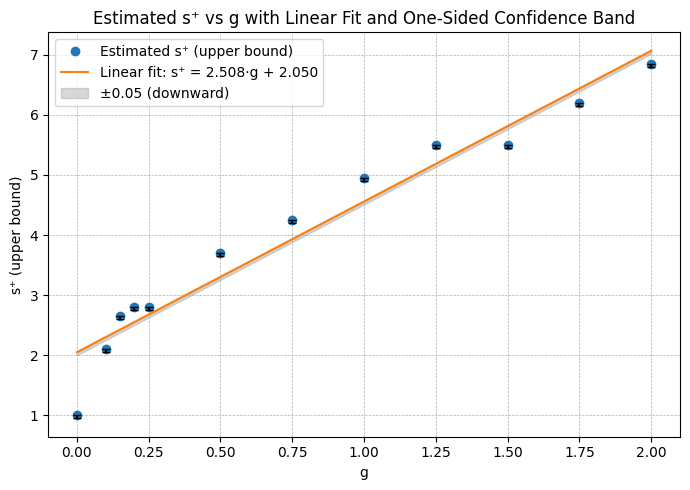

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# Data
g = np.array([0,0.1,0.15,0.2,0.250, 0.500, 0.750, 1.000, 1.250, 1.500, 1.750, 2.000])
s_plus = np.array([1,2.1,2.65,2.8, 2.8, 3.7, 4.25, 4.950, 5.5, 5.500, 6.200,6.85])
error = 0.05  # one-sided confidence bound

# Linear fit: s⁺ = a*g + b
coeffs = np.polyfit(g, s_plus, 1)
a, b = coeffs
fit_line = np.poly1d(coeffs)
g_fit = np.linspace(min(g), max(g), 200)
s_fit = fit_line(g_fit)

# Compute ±0.025 shaded region (only below, since s⁺ is an upper bound)
lower_band = s_fit - error
upper_band = s_fit  # upper bound

# Plot
plt.figure(figsize=(7, 5))
plt.plot(g, s_plus, "o", label="Estimated s⁺ (upper bound)")
plt.plot(g_fit, s_fit, "-", label=f"Linear fit: s⁺ = {a:.3f}·g + {b:.3f}")
plt.fill_between(g_fit, lower_band, upper_band, color="gray", alpha=0.3, label="±0.05 (downward)")
plt.errorbar(g, s_plus, yerr=[[error]*len(g), [0]*len(g)], fmt='none', ecolor='black', capsize=3)

plt.xlabel("g")
plt.ylabel("s⁺ (upper bound)")
plt.title("Estimated s⁺ vs g with Linear Fit and One-Sided Confidence Band")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()